We consider the multidimensional negative logarithm function
$$
f(x) = - \sum_{i=1}^d \log (x_i),
$$
defined on the positive orthant $\{x \in \mathbb{R}^d : x_i > 0 \text{ for all } i\}$, but restricted to the open hypercube $C = (10^{-3}, 10^{-1})^d$ as discussed earlier. This time, we train the approximating ICNN on a training set $\tilde{X} \subseteq C$ obtained as $\tilde{X} = \phi_{\hat{v}}(\tilde{Y})$ from a uniform sample $\tilde{Y}$ in the gradient space $D$ through a neural network approximation $\phi_{\hat{v}}$ of the inverse of $\nabla f$. The neural network $\phi_{\theta} \colon \mathbb{R}^d \to \mathbb{R}^d$ used here has $\tanh$ activation and three hidden layers of sizes $[128,128]$.

For Table \ref{tab:3} it shows estimates of the $L^2$-approximation errors
$$
\|\nabla f \circ \phi_{\hat{v}} - \text{id}\|_{L^2(D , \text{Unif})} \quad \text{and} \quad \|h_{\hat{\theta}} - f^*\|_{L^2(D , \text{Unif})}
$$
along with the times in hours, minutes, and seconds it took to train $\phi_{\hat{v}}$ and $h_{\hat{\theta}}$.

It can be seen that the approximation of $f^*$ is more accurate compared to the direct sampling method. However, the time to train $h_{\hat{\theta}}$ has increased since indirect sampling involves an evaluation of the neural network $\phi_{\hat{v}}$ in the simulation of every random point $x \in \tilde{X}$.

Libraries: JAX.


In [ ]:
# !pip install optax

In [ ]:
# import jax
# import psutil
# import os

# # Function to get CPU info
# def get_cpu_info():
#     cpu_info = {
#         "Physical cores": psutil.cpu_count(logical=False),
#         "Total cores": psutil.cpu_count(logical=True),
#         "Max Frequency": f"{psutil.cpu_freq().max:.2f}Mhz",
#         "Current Frequency": f"{psutil.cpu_freq().current:.2f}Mhz",
#         "CPU Usage": f"{psutil.cpu_percent()}%"
#     }
#     return cpu_info

# # Function to get RAM info
# def get_ram_info():
#     svmem = psutil.virtual_memory()
#     ram_info = {
#         "Total": f"{svmem.total / (1024 ** 3):.2f} GB",
#         "Available": f"{svmem.available / (1024 ** 3):.2f} GB",
#         "Used": f"{svmem.used / (1024 ** 3):.2f} GB",
#         "Percentage": f"{svmem.percent}%"
#     }
#     return ram_info

# # Function to get GPU info using JAX
# def get_gpu_info():
#     gpu_devices = jax.devices()
#     if gpu_devices:
#         gpu_details = [str(device) for device in gpu_devices]
#         return {"GPU(s)": gpu_details}
#     else:
#         return {"GPU": "No GPU found"}

# # Display all info
# cpu_info = get_cpu_info()
# ram_info = get_ram_info()
# gpu_info = get_gpu_info()

# print("CPU Information:", cpu_info)
# print("RAM Information:", ram_info)
# print("GPU Information:", gpu_info)


In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, vmap, lax
from jax.tree_util import tree_leaves
import optax
import matplotlib.pyplot as plt
import yaml
import os
import time
import sys
import json
from scipy.io import savemat
from tqdm import tqdm
from collections import namedtuple
from functools import partial
from typing import Callable, Any, List

# Flax library imports
from flax import linen as nn
from flax.training import train_state


In [ ]:
DPI = 300 # dpi = 300  # Set DPI for higher quality images


In [ ]:
base_path = "/content/drive/MyDrive/ETH/Convex_conjugates/experiments_with_ICNN_2"
 # results of experiments with ICNN that use nonlinear transform to ensure convexity
sys.path.append(base_path)

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Primal QUADRATIC:
def square(x):
    return jnp.reshape(jnp.sum(x*x, -1), ())
# Dual:
square_star_true = lambda x: jnp.sum(x*x, -1) / 4

#########################
# Primal NEGATIVE-ENTROPY
def negative_entropy(x):
    return jnp.reshape(jnp.sum(x * jnp.log(x), -1), ())
# Dual
negative_entropy_star_true = lambda x: jnp.sum(jnp.exp(x - 1), -1)

##########################
# Primal Negative Logarithm
def negative_logarithm(x):
    return -jnp.sum(jnp.log(x), axis=-1)

# Dual of the Negative Logarithm
def negative_logarithm_star_true(y):
    return -jnp.sum(jnp.log(-y), axis=-1) - y.shape[-1]



In [ ]:
class NonNegativeDense(nn.Module):
    features: int
    use_bias: bool = True
    dtype: Any = None
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros
    pre_transform: Callable = jnp.square # Optional pre-transformation

    @nn.compact
    def __call__(self, inputs):
        kernel_shape = (inputs.shape[-1], self.features)
        kernel = self.param('kernel', self.kernel_init, kernel_shape)
        # if self.pre_transform:
        kernel = self.pre_transform(kernel)  # Apply pre-transformation if any
         # Squaring the kernel to ensure non-negative weights
        y = jnp.dot(inputs, kernel)
        if self.use_bias:
            bias = self.param('bias', self.bias_init, (self.features,))
            y += bias
        return y

class ConvexNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = nn.relu  # Default activation; adjust as needed

    @nn.compact
    def __call__(self, x):
        # Adjust to handle specific transformations for the first and last layers if needed
        for i, width in enumerate(self.layer_widths):
            # Use NonNegativeDense with optional pre_transform for the last layer
            if i == 0:  # First layer, using standard nn.Dense
                x = nn.Dense(features=width)(x)
            else:  # Intermediate layers with NonNegativeDense without pre_transform
                x = NonNegativeDense(features=width)(x)
            x = self.activation(x)

        # Final output layer, assuming a single output unit for simplicity
        x = NonNegativeDense(features=1)(x)  # Adjust if different behavior is desired
        return x

def gelu(x):
    return 0.5 * x * (1 + jax.scipy.special.erf(x / jnp.sqrt(2)))

class FCNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = gelu# nn.relu  # Default activation; adjust as needed

    @nn.compact
    def __call__(self, x):
        # Adjust to handle specific transformations for the first and last layers if needed
        for i, width in enumerate(self.layer_widths):
            # Use NonNegativeDense with optional pre_transform for the last layer
            if i > -1:  # First layer, using standard nn.Dense
                x = nn.Dense(features=width)(x)
            else:  # Intermediate layers with NonNegativeDense without pre_transform
                x = NonNegativeDense(features=width)(x)
            x = self.activation(x)

        # Final output layer, assuming a single output unit for simplicity
        x = NonNegativeDense(features=1)(x)  # Adjust if different behavior is desired
        return x



class BNFCNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = gelu #nn.relu  # Default activation; can be customized

    @nn.compact
    def __call__(self, x, train: bool = True):
        for i, width in enumerate(self.layer_widths):
            x = nn.Dense(features=width)(x)
            if i < len(self.layer_widths) - 1:  # Apply BatchNorm and activation to all but the last layer
                x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)
                x = self.activation(x)
        return x

# Configuration Parameters

- **experiment_name**: A string used to uniquely identify and track the experiment.
- **description**: A string describing the purpose or details of the experiment.
- **dim**: An integer representing the dimensionality of the input space.
- **layer_widths**: A list of integers specifying the number of units in each layer of the neural network.
- **num_epochs**: An integer representing the number of epochs to train the model.
- **batch_size**: An integer specifying the size of each training batch.
- **steps**: An integer representing the number of steps the model takes per batch, relevant when mini-batch optimization is used (i.e., when `use_grid` is False).
- **start**: A float or list of floats representing the start point(s) of the rectangular domain for the primal variables \( x \).
- **end**: A float or list of floats representing the end point(s) of the rectangular domain for the primal variables \( x \).
- **convrg_eps**: A float specifying the convergence threshold epsilon for stopping the training.
- **learning_rate**: A float representing the learning rate for the optimizer.
- **l2_regularization_coefficient**: A float for the L2 regularization term to prevent overfitting.
- **N_ae**: An integer specifying the number of epochs for pretraining an autoencoder, if applicable.
- **v_init_fn**: A callable function for initializing the parameters. For instance, it could be a function that generates random values within a certain range.
- **minval**: A float or list of floats indicating the minimum value(s) for the gradient domain, corresponding to the dual variables \( y \).
- **maxval**: A float or list of floats indicating the maximum value(s) for the gradient domain, corresponding to the dual variables \( y \).
- **y_func**: A callable function defining the behavior or computation of the dual variables \( y \).
- **y_func_star**: A callable function representing the true conjugate of \( y \).

## Domain Explanation

- **Primal Domain (`start` to `end`)**: The domain for the primal variables \( x \) is defined as \([start, end]^d\).
- **Dual Domain (`minval` to `maxval`)**: The domain for the dual variables \( y \) is defined as \([minval, maxval]^d\).

The correct transformation between the domains is $\nabla f: H \to K$  and $\nabla^{-1} f: K\to H$ realized below with approximate inverse mappings.

In [ ]:
LEARNING_RATE = 3e-4
ALPHA = 1e-8 #

Config = namedtuple("Config",
                    [
                     "experiment_name",        # Name of the experiment for tracking purposes
                     "description",            # Description of the experiment
                     "dim",                    # Dimensionality of the input space
                     "layer_widths",           # Widths of each layer in the neural network
                     "num_epochs",             # Number of epochs for training
                     "batch_size",             # Batch size for training
                     "steps",                  # Number of steps per batch (useful if use_grid is False)
                     "start",                  # Start point of the primal domain (rectangular domain start)
                     "end",                    # End point of the primal domain (rectangular domain end)
                     "convrg_eps",             # Convergence epsilon for stopping criterion
                    "ae_convrg_eps",             # Convergence epsilon for stopping criterion for ae
                     "learning_rate",          # Starting value of the learning rate for the optimizer
                     "learning_rate_ae",
                     "N_ae",                   # Number of epochs for autoencoder pretraining
                     "v_init_fn",              # Initialization function for the parameters
                     "minval",                 # Minimum value for the gradient domain (dual domain start)
                     "maxval",                 # Maximum value for the gradient domain (dual domain end)
                     "f_func",                 # Function definition for y (dual variables)
                     "f_func_star",             # True function conjugate for y
                     "train_sampling",         # use inverse sampling for train
                     "test_sampling"           # use inverse sampling for test
                    ])




In [ ]:
cfg = Config(
    experiment_name = "Negative_LOG_inverse_sampling_d=2",               # Name of the experiment for tracking purposes
    description = "Negative_LOG_inverse_sampling_d=2",        # Description of the experiment
    dim = 2,                               # Dimensionality of the input space
    layer_widths = (256, 256),           # Widths of each layer in the neural network
    num_epochs = 200000,                   # Number of epochs for training
    N_ae = 10000,                           # Number of epochs for autoencoder pretraining
    batch_size = 6200,                      # Batch size for training
    steps = 1,                              # Number of steps per batch (useful if use_grid is False)
    start = 0.001,                              # Start point of the primal domain (rectangular domain start point)
    end = 0.1,                                # End point of the primal domain (rectangular domain end point)
    minval = -1000,                             # Minimum value for the gradient domain (dual domain start)
    maxval = -10,                            # Maximum value for the gradient domain (dual domain end)
    ae_convrg_eps = 1e-9,                   #  Convergence epsilon for  ae stopping
    convrg_eps = 1e-5,                      # Convergence epsilon for stopping criterion
    learning_rate = 3e-3,                   # Learning rate for the optimizer
    learning_rate_ae  = 3e-4,
    v_init_fn = "V_INIT_Uniform",           # Initialization function for the parameters
    f_func = "negative_logarithm",            # Function definition for f (dual variables)
    f_func_star = "negative_logarithm_star_true", # True function conjugate for f*
    train_sampling = True, # use inverse sampling for train
    test_sampling = True, # use inverse sampling for test
)


# path_to_results_and_cfgs = os.path.join(base_path, "Experiment_test")

# # Path to the YAML file
# config_path = os.path.join(path_to_results_and_cfgs, 'config.yaml')

# # Save the config to the YAML file
# save_config_to_yaml(cfg, config_path)

In [ ]:
# Map the string names to the actual functions
function_mapping = {
    "square": square,
    "square_star_true" : square_star_true,
    "negative_entropy": negative_entropy,
    "negative_entropy_star_true" : negative_entropy_star_true,
    "negative_logarithm": negative_logarithm,
    "negative_logarithm_star_true": negative_logarithm_star_true,
    # Add other functions...
}




# Some saving/loading utils:

In [ ]:
def save_statistics(statistics, path_to_save, filename):
    # Convert JAX arrays to NumPy arrays, NumPy arrays to lists, and float32 to float
    serializable_stats = {}
    for k, v in statistics.items():
        if isinstance(v, (jnp.ndarray, np.ndarray)):
            v = jax.device_get(v).tolist()
        elif isinstance(v, np.float32):
            v = float(v)
        serializable_stats[k] = v

    print("Statistics:")
    for key, value in statistics.items():
        print(f"  {key}: {value}")

    full_path = os.path.join(path_to_save, filename)
    with open(full_path, 'w') as file:
        json.dump(serializable_stats, file)


In [ ]:
def save_config_to_yaml(config, path):
    with open(path, 'w') as file:
        yaml.dump(dict(config._asdict()), file)

# Some plotting/statistics utils:

In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

def plot_results(d, eval_grad_f_x, preds, vmap_f_star_true, state, const_val, train_loss_list, eval_loss_list):
    """
    Plots evaluation results and calculates residuals.

    Args:
        d (int): Dimensionality of the input space.
        eval_grad_f_x (array): Evaluated gradient values.
        preds (array): Predictions from the model.
        vmap_f_star_true (callable): Function to compute true conjugate values.
        state (train_state.TrainState): Training state containing model parameters.
        const_val (float): Constant value for plotting higher dimensions.
        Loss (list): List of loss values over epochs.
    """

    dpi = 100  # You can adjust DPI if needed

    font_size = 20  # Large font size for titles, labels, and legends

    if d == 1:
        # Sort and plot for 1D
        eval_grad_f_x = np.squeeze(eval_grad_f_x)
        indices = np.argsort(eval_grad_f_x)
        eval_grad_f_x, preds = eval_grad_f_x[indices], preds.flatten()[indices].reshape(-1, 1)
        plt.figure(dpi=dpi)
        plt.plot(eval_grad_f_x, preds, lw=3, label='Predictions')
        plt.plot(eval_grad_f_x, vmap_f_star_true(eval_grad_f_x.reshape(-1, 1)), lw=3, label='True Conjugate')
        plt.xlabel('eval_grad_f_x', fontsize=font_size)
        plt.ylabel('Function Values', fontsize=font_size)
        plt.title('Sorted Points and Function Values', fontsize=font_size)
        plt.legend(fontsize=font_size)
        plt.grid(True)
        plt.show()

        # Calculate and print RMSE (residual)
        accuracy = 1 / np.sqrt(eval_grad_f_x.shape[0]) * jnp.linalg.norm(preds.reshape(-1, 1) - vmap_f_star_true(eval_grad_f_x).reshape(-1, 1))
        print("Residual:", accuracy)

    if d >= 2:
        # Scatter plot for first two components in 2D+
        start = jnp.min(eval_grad_f_x)
        end = jnp.max(eval_grad_f_x)
        plt.figure(dpi=dpi)
        plt.scatter(eval_grad_f_x[:, 0], eval_grad_f_x[:, 1], c='red', marker='o', s=30)  # Increased marker size
        plt.xlabel(r'$y_1$', fontsize=font_size)
        plt.ylabel(r'$y_2$', fontsize=font_size)
        plt.title('Scatter Plot of sampling in D', fontsize=font_size)
        plt.grid(True)
        plt.show()

        def generate_1D_line_in_dD_space(axis, const_val, start, end, num_points=100, d=d):
            x = jnp.linspace(start, end, num_points)
            line_dD = jnp.ones((num_points, d)) * const_val
            line_dD = line_dD.at[:, axis].set(x)
            return line_dD

        def calculate_and_plot(axis, const_val):
            line_dD = generate_1D_line_in_dD_space(axis, const_val, start, end)
            f_x = state.apply_fn({'params': state.params}, line_dD)
            f_star_true_x = vmap_f_star_true(line_dD)

            # Calculate and print RMSE along the axis
            accuracy = 1 / np.sqrt(line_dD.shape[0]) * jnp.linalg.norm(f_x.reshape(-1, 1) - f_star_true_x.reshape(-1, 1))
            print("Residual along axis {} @ value = {}: {}".format(axis, const_val, accuracy))

            plt.figure(dpi=dpi)
            plt.plot(line_dD[:, axis], f_x, lw=4, label=r'$g_{\hat{\theta}}$')
            plt.plot(line_dD[:, axis], f_star_true_x, lw=4,  ls='--', label='True Conjugate')
            ax = axis+1
            print('ax = ', ax)
            ax_name = f'$y_{{{ax}}}$'
            plt.xlabel(rf'{ax_name}', fontsize=font_size)
            plt.title('Numerical and Analytical DLT along axis {}'.format(axis+1), fontsize=font_size)
            plt.legend(fontsize=font_size)
            plt.grid(True)
            plt.show()

        calculate_and_plot(axis=0, const_val=const_val)
        calculate_and_plot(axis=1, const_val=const_val)

    # Plot training loss over epochs
    plt.figure(dpi=100)
    plt.plot(train_loss_list, lw=3, label='Training Loss')
    plt.plot(eval_loss_list, lw=3, label='Evaluation Loss')
    plt.xlabel('Epochs', fontsize=font_size)
    plt.ylabel('Loss', fontsize=font_size)
    plt.title('Training and Evaluation Loss Over Epochs', fontsize=font_size)
    plt.legend(fontsize=font_size)
    plt.grid(True)
    plt.show()


In [ ]:
def descriptive_statistics(data, name="Data"):
    """Returns descriptive statistics for the given data as a dictionary."""
    data = np.array(data)
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    minimum = np.min(data, axis=0)
    maximum = np.max(data, axis=0)
    shape = data.shape

    statistics = {
        "name": name,
        "shape": shape,
        "mean": mean,
        "std_dev": std_dev,
        "min": minimum,
        "max": maximum
    }

    return statistics


In [ ]:
def calculate_statistics(y, preds, vmap_f_star_true, cfg = cfg):
    """
    Calculate various statistics for evaluating the model's performance.

    Args:
        y (array): Batch of  values from gradiant space (from set D).
        preds (array): Predictions from the model.
        vmap_f_star_true (callable): Function to compute true conjugate values.
        loss_value (float): The loss value from the model.

    Returns:
        acc (float): Root Mean Squared Error (RMSE) between predictions and true values, excluding infinities.
        max_acc (float): Maximum error between predictions and true values, excluding infinities.
        res (float): Square root of the loss value.
        mre (float): Mean Relative Error (MRE) between predictions and true values, excluding infinities.
    """
    # Calculate true conjugate values
    f_star_values = vmap_f_star_true(y)

    # Identify points where vmap_f_star_true gives infinity
    is_finite = jnp.isfinite(f_star_values)

    # Apply the mask to filter out infinite points
    finite_preds = preds[is_finite]
    finite_f_star_values = f_star_values[is_finite]

    # Reshape for calculation
    finite_preds_reshaped = finite_preds.reshape(-1, 1)
    finite_f_star_values_reshaped = finite_f_star_values.reshape(-1, 1)

    # Calculate RMSE excluding infinite points

    acc = 1 / np.sqrt(finite_preds_reshaped.shape[0]) * jnp.linalg.norm(finite_preds_reshaped - finite_f_star_values_reshaped)

    # Calculate maximum error excluding infinite points
    max_acc = jnp.max(jnp.abs(finite_preds_reshaped - finite_f_star_values_reshaped))

    # Calculate Mean Relative Error (MRE), avoiding division by zero
    relative_errors = jnp.where(finite_f_star_values_reshaped != 0,
                                jnp.abs((finite_preds_reshaped - finite_f_star_values_reshaped) / finite_f_star_values_reshaped),
                                0)
    mre = jnp.mean(relative_errors)

    # Calculate square root of the loss value

    # if loss_value is not None:
    #     res = np.sqrt(loss_value)
    # else:
    #     res = None  # Or handle the None case differently as need

    return acc, max_acc, mre


# RUN **SINGLE** EXPERIMENT

## JAX tricks:

We vmap all the funcitons for efficient computing.

In [ ]:
initial_key = jax.random.PRNGKey(0)

f = function_mapping[cfg.f_func]
f_star_true =  function_mapping[cfg.f_func_star]

# Wrapping the modified objective function with grad, jit, and vmap
grad_f_fn = jax.grad(f, argnums=0)
grad_f = jax.jit(grad_f_fn)

# Vectorization for processing batches of inputs "vmap_f_epsilon"
vmap_grad_f = vmap(grad_f, in_axes = 0)
vmap_f = vmap(f, in_axes = 0)
vmap_f_star_true = vmap(f_star_true, in_axes = 0)


## Approximate Inverse Mapping

Since our goal is to approximate $f^*(y)$, in some cases, it might be beneficial to train the model on samples $\{y_i\}$ that have some desired distribution $\nu$. For example, $\nu$ can be a uniform distribution on some compact subset $K$ of $D$. However, if we sample $d$-dimensional $x$ uniformly, then the gradient $\nabla f(x)$ will (generally) not have a $d$-dimensional uniform distribution.

The desired $x$-sample can be obtained as $\{(\nabla f)^{-1}(z)\}$, where $(\nabla f)^{-1}(z)$ is some element from the preimage, and $z$ is sampled according to $\nu$ on $K$. In some cases, the inverse mapping $(\nabla f)^{-1}$ exists and can be found analytically; however, generally, we have to rely on approximations.

One approach to address this problem is to prelearn the domain. This involves learning the domain of the mapping in advance to ensure accurate and efficient sampling.

To address this problem, we introduce the concept which we call \textit{the approximate inverse mapping}. The idea is as follows:
Let $\Psi:\mathbb{R}^d \to \mathbb{R}^d$ be some mapping.

1. We can learn $\Psi^{-1}$ (preimage) as a decoder in an "autoencoder type" architecture:
$$
x \xrightarrow{\mathfrak{e}} \Psi(x) \xrightarrow{\mathfrak{d}} x
$$
where the encoder $\mathfrak{e}$ is set equal to $\Psi$. The decoder part, $\mathfrak{d}: \psi \mapsto x$, will provide an approximate inverse to the mapping $\Psi$ if $\Psi$ is invertible, and an element from the preimage otherwise.

2. We can learn $\Psi^{-1}$ (preimage) as an encoder in an "autoencoder type" architecture:
$$
y \xrightarrow{\mathfrak{e}} \Psi^{-1}(y) \xrightarrow{\mathfrak{d}} y
$$
where the decoder $\mathfrak{d}$ is set equal to $\Psi$. The encoder part, $\mathfrak{e}: y \mapsto x$, will provide an approximate inverse to the mapping $\Psi$ if $\Psi$ is invertible, and an element from the preimage otherwise.

If the domain of $\Psi$ is known to be large (a totally safe option is the whole $\mathbb{R}^d$, otherwise one needs to sample with rejection), then we can safely use the second variant, which is generally more convenient. Otherwise, the first option is safer.

As a result, one can sample from the distribution $\nu$ in the $\{\psi\}$ space so that $\mathfrak{d}(\psi)$ generates $\{x\}$-samples, which will (approximately) have the desired property.

In some cases, when $\Psi$ is invertible, it is also possible to learn the encoder and decoder simultaneously, which can improve efficiency and convergence.

$$\begin{cases}
x \xrightarrow{\nabla} \Psi(x) \xrightarrow{\mathfrak{d}} x \\
y \xrightarrow{\mathfrak{e}} \Psi^{-1}(y) \xrightarrow{\nabla} y
\end{cases},$$

enforcing $\mathfrak{d} = \mathfrak{e}$. In our experiments, this improved the domain learning for $\mathfrak{e}$ and learning speed. If necessary, it can be easily adjusted to include cases 1 and 2.

### Training Inverse of Mapping $G$

To adapt the model to learn the inverse of a composite mapping $G = g \circ \Psi$, where $g: \mathbb{R} \to \mathbb{R}$ is a predefined function such as $g(y) = \frac{1}{y}$, follow these steps:

1. **Define $G$ and $g$**:
   $$
   G(x) = g(\Psi(x))
   $$
   For example, if $g(y) = \frac{1}{y}$, then $G(x) = \frac{1}{\Psi(x)}$.

2. **Modify the Loss Function**:
   Update the loss function to incorporate $G$ and its inverse $G^{-1}$.

3. **Train the Model**:
   Train the model to learn the inverse of $G$, denoted as $G^{-1}$. Once $G^{-1}$ is learned, $\Psi^{-1}$ can be restored using $G^{-1}$ and $g$:
   $$
   \Psi^{-1}(y) = G^{-1}(g(y))
   $$


In [ ]:
# # Example training loop setup
n_samples = cfg.batch_size * 10
batch_size = cfg.batch_size

import time



In [ ]:
from base64 import encode
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
import os
from flax.training import train_state
from jax import grad, vmap
from functools import partial
from jax import random
import numpy as np
import pickle
import time

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    d: int  # Dimensionality

    def setup(self):
        self.fc1 = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.fc2 = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.fc3 = nn.Dense(self.d, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.tanh = nn.tanh

    def __call__(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Define gradient mapping
def h(x, f):
    return grad(f)(x)

# Define function g and operator G
def g(y):
    return -1/y

def G(x, f):
    return g(h(x, f))

# Define primal_function
primal_function = f

# Initialize the autoencoder
d = cfg.dim  # Dimensionality
key = random.PRNGKey(0)
autoencoder = Autoencoder(d=d)
x_dummy = jnp.zeros((1, d))
params = autoencoder.init(key, x_dummy)['params']

# Uniform sampling random generator
@partial(jax.jit, static_argnums=(1, 2))
def uniform_sampling_random_generator(key, batch_size, dim, minval, maxval):
    return random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)

# Create the optimizer
lr_schedule = optax.exponential_decay(
    init_value=1e-5,
    transition_steps=1000,
    decay_rate=0.95,
    staircase=True
)
optimizer = optax.adam(lr_schedule)

encoder_loss_factor = 1e1/cfg.start
decoder_loss_factor = 1e1/cfg.start

# Initialize training state
ae_state = train_state.TrainState.create(
    apply_fn=autoencoder.apply,
    params=params,
    tx=optimizer
)

# Estimate y-space range
def estimate_y_space_range(key, num_samples, batch_size, dim):
    x_samples = []
    for _ in range(num_samples // batch_size):
        key, subkey = random.split(key)
        x_samples.append(uniform_sampling_random_generator(subkey, batch_size, dim, cfg.start, cfg.end))
    x_samples = jnp.concatenate(x_samples, axis=0)
    y_samples = jax.vmap(lambda xi: h(xi, primal_function))(x_samples)
    min_y = jnp.min(y_samples, axis=0)
    max_y = jnp.max(y_samples, axis=0)
    return min_y, max_y

# Estimate the range for y-space
# min_y, max_y = estimate_y_space_range(key, cfg.batch_size * 10, cfg.batch_size, d)
min_y, max_y = cfg.minval, cfg.maxval

# Loss function for training
def loss_fn(params, x, z):
    # Encode x to get encoding target
    encoding_target = jax.vmap(G, in_axes=(0, None))(x, primal_function)

    # Decode the encoding target to reconstruct x
    decoding = autoencoder.apply({'params': params}, encoding_target)

    # Calculate the decoder loss as the mean squared error between x and its reconstruction
    decoder_loss = jnp.mean(jnp.square((decoding - x)*decoder_loss_factor))

    # Decode z to get decoding target
    decoding_target = autoencoder.apply({'params': params}, z)

    # Re-encode the decoding target to reconstruct z
    reencoded = jax.vmap(G, in_axes=(0, None))(decoding_target, primal_function)

    # Create a mask to filter out non-finite values in reencoded and z
    finite_mask = jnp.logical_and(jnp.isfinite(reencoded).all(axis=1), jnp.isfinite(z).all(axis=1))

    # Apply the mask to reencoded and z
    reencoded = jnp.where(finite_mask[:, None], reencoded, jnp.zeros_like(reencoded))
    z = jnp.where(finite_mask[:, None], z, jnp.zeros_like(z))

    # Calculate the encoder loss as the mean squared error between z and its reconstruction
    encoder_loss = jnp.mean(jnp.square((reencoded - z)*encoder_loss_factor)) if reencoded.size > 0 else 0.0

    # Return individual losses and their sum
    return decoder_loss, encoder_loss, (decoder_loss + encoder_loss)

# Gradient function
@jax.jit
def train_step(ae_state, x, z):
    def loss(params):
        return loss_fn(params, x, z)[2]
    grads = grad(loss)(ae_state.params)
    return ae_state.apply_gradients(grads=grads)

# Save model function
def save_model(ae_state, path):
    with open(path, 'wb') as f:
        pickle.dump(ae_state.params, f)

# Load model function
def load_model(path, ae_state):
    with open(path, 'rb') as f:
        params = pickle.load(f)
    ae_state = ae_state.replace(params=params)
    return ae_state

# Psi^-1 generator
@partial(jax.jit, static_argnums=(1, 2, 3, 4))
def psi_inv_generator(key, batch_size, dim, minval, maxval):
    y_samples = uniform_sampling_random_generator(key, batch_size, dim, minval, maxval)
    z_samples = g(y_samples)
    return autoencoder.apply({'params': params}, z_samples)

# Plotting function to observe the progress
def plot_progress(uniform_samples_z, gradient_mapped_encoded_samples, x_batch, encoded_samples_x, decoded_samples_x, Psi_inv_samples, epoch, current_lr, decoder_loss, encoder_loss, total_loss, z_samples, save_fig=True):
    if d >= 2:
        fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=DPI)

        # Plot 1: Uniform in z-space vs Gradient Mapped Samples
        axes[0].scatter(uniform_samples_z[:, 0], uniform_samples_z[:, 1], color='blue', alpha=0.6, label='Uniform Samples in z-space')
        axes[0].scatter(gradient_mapped_encoded_samples[:, 0], gradient_mapped_encoded_samples[:, 1], color='red', alpha=0.6, label='Gradient Mapped Decoded Samples')
        axes[0].set_xlabel('Component 0 of z')
        axes[0].set_ylabel('Component 1 of z')
        axes[0].set_title(f'Epoch {epoch+1} - Uniform in z-space vs Gradient Mapped Samples\nLearning Rate: {current_lr:.6f}\n Encoder Loss: {encoder_loss:.4f}, Total Loss: {total_loss:.4f}')
        axes[0].legend(loc='lower right')

        # Plot 2: Decoded Samples and x_batch
        axes[1].scatter(x_batch[:, 0], x_batch[:, 1], color='blue', alpha=0.6, label='x_batch Samples')
        axes[1].scatter(decoded_samples_x[:, 0], decoded_samples_x[:, 1], color='green', alpha=0.6, label='Decoded Samples')
        axes[1].set_xlabel('Component 0 of x')
        axes[1].set_ylabel('Component 1 of x')
        axes[1].set_title(f'Epoch {epoch+1} - Decoded Samples\nLearning Rate: {current_lr:.6f}\nDecoder Loss: {decoder_loss:.4f}, Total Loss: {total_loss:.4f}')
        axes[1].legend(loc='lower right')

        # Plot 3: Psi^-1(g(y))
        if z_samples is not None:
            axes[2].scatter(Psi_inv_samples[:, 0], Psi_inv_samples[:, 1], color='orange', alpha=0.6, label='Psi^{-1}(g(y)) Samples')
        axes[2].set_xlabel('Component 0 of x')
        axes[2].set_ylabel('Component 1 of x')
        axes[2].set_title(f'Epoch {epoch+1} - Psi^{-1}(g(y))\nLearning Rate: {current_lr:.6f}')
        axes[2].legend(loc='lower right')

        if save_fig:
            plt.savefig(f'/content/plots/epoch_{epoch+1}.png')
        plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_gradient_space(image_under_grad_f_of_Psi_inv_samples, y_batch, h_x_batch, epoch, save_fig=False):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=300)
    ax[0].scatter(y_batch[:,0], y_batch[:,1], label='Unif. sampling in gradient space')
    ax[0].scatter(image_under_grad_f_of_Psi_inv_samples[:,0], image_under_grad_f_of_Psi_inv_samples[:,1], label='Approximate inverse sampling')

    ax[0].set_xlabel('Component 0 of y')
    ax[0].set_ylabel('Component 1 of y')
    ax[0].set_title(f'Epoch {epoch+1} - Gradient Space')
    ax[0].legend(loc='lower right')

    ax[1].scatter(y_batch[:,0], y_batch[:,1], label='Unif. sampling in gradient space' )
    ax[1].scatter(h_x_batch[:,0], h_x_batch[:,1], label=r'Direct sampling: $y \sim \nabla f \circ \mathrm{Unif}$')

    ax[1].set_xlabel('Component 0 of y')
    ax[1].set_ylabel('Component 1 of y')
    ax[1].legend(loc='lower right')

    if save_fig:
        plt.savefig(f'/content/plots/gradient_space_epoch_{epoch+1}.png')

    plt.show()



# Training function
def train_autoencoder(ae_state, key, num_epochs, batch_size, start_epoch=0):
    for epoch in range(start_epoch, start_epoch + num_epochs):

        key, subkey = random.split(key)
        x_batch = uniform_sampling_random_generator(subkey, batch_size, d, cfg.start, cfg.end)

        key, subkey = random.split(key)
        y_batch = uniform_sampling_random_generator(subkey, batch_size, d, min_y, max_y)
        a = jnp.minimum(g(min_y), g(max_y))
        b = jnp.maximum(g(min_y), g(max_y))
        z_batch = uniform_sampling_random_generator(subkey, batch_size, d, a, b)

        ae_state = train_step(ae_state, x_batch, z_batch)

        if epoch == start_epoch + num_epochs - 1:
            save_model(ae_state, f'/content/model_weights/{cfg.f_func}_autoencoder_epoch_{epoch+1}.pkl')

        if epoch % 5000 == 0:
            print("=========================================")
            print(f"Epoch [{epoch + 1}/{start_epoch + num_epochs}]")
            print("=========================================")
            z_samples = jax.vmap(G, in_axes=(0, None))(x_batch, primal_function)
            decoded_samples_x = autoencoder.apply({'params': ae_state.params}, z_samples)
            encoded_samples_x = autoencoder.apply({'params': ae_state.params}, z_batch)
            Psi_inv_samples = autoencoder.apply({'params': ae_state.params}, g(y_batch))

            image_under_grad_f_of_Psi_inv_samples = jax.vmap(h, in_axes=(0, None))(Psi_inv_samples, primal_function)

            h_x_batch = jax.vmap(h, in_axes=(0, None))(x_batch, primal_function)

            plot_gradient_space(image_under_grad_f_of_Psi_inv_samples, y_batch, h_x_batch , epoch, save_fig=False)

            gradient_mapped_encoded_samples = jax.vmap(G, in_axes=(0, None))(encoded_samples_x, primal_function)

            decoder_loss, encoder_loss, total_loss = loss_fn(ae_state.params, x_batch, z_batch)
            current_lr = lr_schedule(epoch)
            print(f"Epoch [{epoch + 1}/{start_epoch + num_epochs}], Total Loss: {total_loss:.8f}, Decoder Loss: {decoder_loss:.8f}, Encoder Loss: {encoder_loss:.8f}, Learning Rate: {current_lr:.6f}")

            plot_progress(z_batch, gradient_mapped_encoded_samples, x_batch, encoded_samples_x, decoded_samples_x, Psi_inv_samples, epoch, current_lr, decoder_loss, encoder_loss, total_loss, z_samples)

            # ae_loss = total_loss
            normalization_coef = (max_y - min_y)*jnp.sqrt(d)/2
            ae_loss = (jnp.mean(jnp.square(image_under_grad_f_of_Psi_inv_samples - y_batch)))/normalization_coef # ae_loss for the right inverse; normalization to make it compaprable with left inverse, due to diffferent domains

    return ae_state, ae_loss

# Create the directory to save model weights if it does not exist
model_weights_path = '/content/model_weights'
os.makedirs(model_weights_path, exist_ok=True)

# Optionally create directory to save plots
plots_path = '/content/plots'
os.makedirs(plots_path, exist_ok=True)

# Calculate runtime
start_time = time.time()

# Train the autoencoder
num_epochs_total = 20000  # cfg.num_epochs
ae_state, ae_loss = train_autoencoder(ae_state, key, num_epochs_total, cfg.batch_size)

end_time = time.time()
ae_runtime = end_time - start_time

print(f"Autoencoder training runtime: {ae_runtime:.2f} seconds")
print(f"Autoencoder loss: {ae_loss:.2f} ")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Define the function to apply the encoder
def apply_encoder(params, inputs):
    return  autoencoder.apply({'params': ae_state.params}, g(inputs)) #autoencoder.apply({'params': params}, inputs)

# Generate y_samples uniformly
def generate_y_samples_uniformly(key, batch_size, dim, minval, maxval):
    return random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)

# Placeholder for psi function
def psi(x):
    return grad(primal_function)(x)


# Small sample exercise
sample_size = 1
y_samples = generate_y_samples_uniformly(random.PRNGKey(25), sample_size, cfg.dim, cfg.minval, cfg.maxval)
x_samples = apply_encoder(ae_state.params, y_samples)
y_reconstructed = jax.vmap(h, in_axes=(0, None))(x_samples, primal_function) #jax.vmap(psi, in_axes=(0,))(x_samples)
print("y-sample       x-sample       y-reconstructed")
for y, x, y_rec in zip(y_samples, x_samples, y_reconstructed):
    print(f"{y} -> {x} -> {y_rec}")



y-sample       x-sample       y-reconstructed
[-310.22876 -284.82605] -> [0.0032166  0.00350297] -> [-310.8873  -285.47208]


In [ ]:
encoder_params = ae_state.params

# After training, perform the small sample exercise to verify the encoder's generalization
sample_size = 2
y_samples = generate_y_samples_uniformly(key, sample_size, cfg.dim, cfg.minval, cfg.maxval)

# Apply encoder to y-samples to get x-samples
x_samples = apply_encoder(encoder_params, y_samples)

# Apply gradient mapping to x-samples to get y-reconstructed
y_reconstructed = jax.vmap(psi, in_axes=(0,))(x_samples)

# Print the results after training
print("After Training:")
print("y-sample       x-sample       y-reconstructed")
for y, x, y_rec in zip(y_samples, x_samples, y_reconstructed):
    print(f"{y} -> {x} -> {y_rec}")

After Training:
y-sample       x-sample       y-reconstructed
[ -44.331787 -777.09265 ] -> [0.02255396 0.00128012] -> [ -44.33811 -781.1781 ]
[-373.30035 -706.58203] -> [0.00267109 0.00140719] -> [-374.3794  -710.63763]


In [ ]:
import jax
import jax.numpy as jnp

def x_uniform_sampling_generator(cfg, key, minval_x=None, maxval_x=None):
    minval_x = minval_x if minval_x is not None else cfg.start
    maxval_x = maxval_x if maxval_x is not None else cfg.end
    while True:
        key, subkey = jax.random.split(key)
        U = jax.random.uniform(key=subkey, shape=(cfg.batch_size, cfg.dim), minval=minval_x, maxval=maxval_x)
        yield U

def y_uniform_sampling_generator(cfg, key, minval_y=None, maxval_y=None):
    minval_y = minval_y if minval_y is not None else cfg.minval
    maxval_y = maxval_y if maxval_y is not None else cfg.maxval
    while True:
        key, subkey = jax.random.split(key)
        U = jax.random.uniform(key=subkey, shape=(cfg.batch_size, cfg.dim), minval=minval_y, maxval=maxval_y)
        yield U

def create_inverse_uniform_sampling_random_generator(cfg, key, minval, maxval,encoder_params, encoder):
    while True:
        batch_fulfilled = False
        while not batch_fulfilled:
            key, subkey = jax.random.split(key)
            y_samples = generate_y_samples_uniformly(subkey, cfg.batch_size, cfg.dim, minval, maxval)
            x_samples = apply_encoder(encoder_params, y_samples) #encoder({'params': params}, y_samples)
            yield x_samples
            batch_fulfilled = True
            # if cfg.start is not None and cfg.end is not None:
            #     is_within_domain = jnp.logical_and(x_samples >= cfg.start, x_samples <= cfg.end).all(axis=-1)
            #     filtered_samples = x_samples[is_within_domain]
            # else:
            #     filtered_samples = x_samples

            # if filtered_samples.size > 0:
            #     yield filtered_samples
            #     batch_fulfilled = True

# Replace the following placeholder functions with your actual implementations
def generate_y_samples_uniformly(key, batch_size, dim, minval = cfg.minval, maxval = cfg.maxval):
    return jax.random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)


def descriptive_statistics(x_samples, name="Data"):
    # Compute and return statistics
    return {
        'min': jnp.min(x_samples, axis=0),
        'max': jnp.max(x_samples, axis=0),
        'mean': jnp.mean(x_samples, axis=0),
        'std': jnp.std(x_samples, axis=0)
    }

# Initialize parameters and generators
encoder_params = ae_state.params
x_inverse_sampling = create_inverse_uniform_sampling_random_generator(cfg, key, cfg.minval, cfg.maxval, encoder_params, apply_encoder)

# # Generate y-samples uniformly for testing
# y_samples = generate_y_samples_uniformly(key, cfg.batch_size, cfg.dim, cfg.minval, cfg.maxval)

# # Apply encoder to y-samples to get x-samples
# x1 = apply_encoder(encoder_params, y_samples)

# # Compute and display descriptive statistics for the generated data
# stat = descriptive_statistics(x1, name="Inverse Sampling Data")

# start_x = jnp.min(stat['min'])
# end_x = jnp.max(stat['max'])

# Initialize the uniform sampling generator
# uniform_x_generator = generate_x_samples_uniformly(cfg, key)
x_uniform_sampling =x_uniform_sampling_generator(cfg, key, minval_x= cfg.start, maxval_x=cfg.end) #  generate_x_samples_uniformly(cfg, key, minval_x=cfg.start, maxval_x=cfg.end)
y_uniform_sampling = y_uniform_sampling_generator(cfg, key, minval_y= cfg.minval, maxval_y=cfg.maxval)

minval = cfg.minval  # = minval_y
maxval = cfg.maxval  # = maxval_y


In [ ]:
%time x1 = next(x_inverse_sampling)
%time x2 = next(x_uniform_sampling )

descriptive_statistics(x1, name="Inverse Sampling Data")
descriptive_statistics(x2, name="Uniform Sampling Data")



CPU times: user 197 ms, sys: 5.4 ms, total: 202 ms
Wall time: 169 ms
CPU times: user 170 ms, sys: 7.39 ms, total: 177 ms
Wall time: 148 ms


{'min': Array([0.00100389, 0.0010002 ], dtype=float32),
 'max': Array([0.09998244, 0.09999596], dtype=float32),
 'mean': Array([0.04901501, 0.05108467], dtype=float32),
 'std': Array([0.02868906, 0.02863311], dtype=float32)}

In [ ]:
# key, subkey = jax.random.split(key)
# y_samples = generate_y_samples_uniformly(subkey, cfg.batch_size, cfg.dim, minval, maxval)
# x_samples = apply_encoder({'params': params}, y_samples)

# is_within_domain = jnp.logical_and(x_samples >= cfg.start, x_samples <= cfg.end).all(axis=-1)


In [ ]:
# x1, x2, x1.shape
# next(x_inverse_sampling)
# x_samples, is_within_domain ,  cfg.start, cfg.end

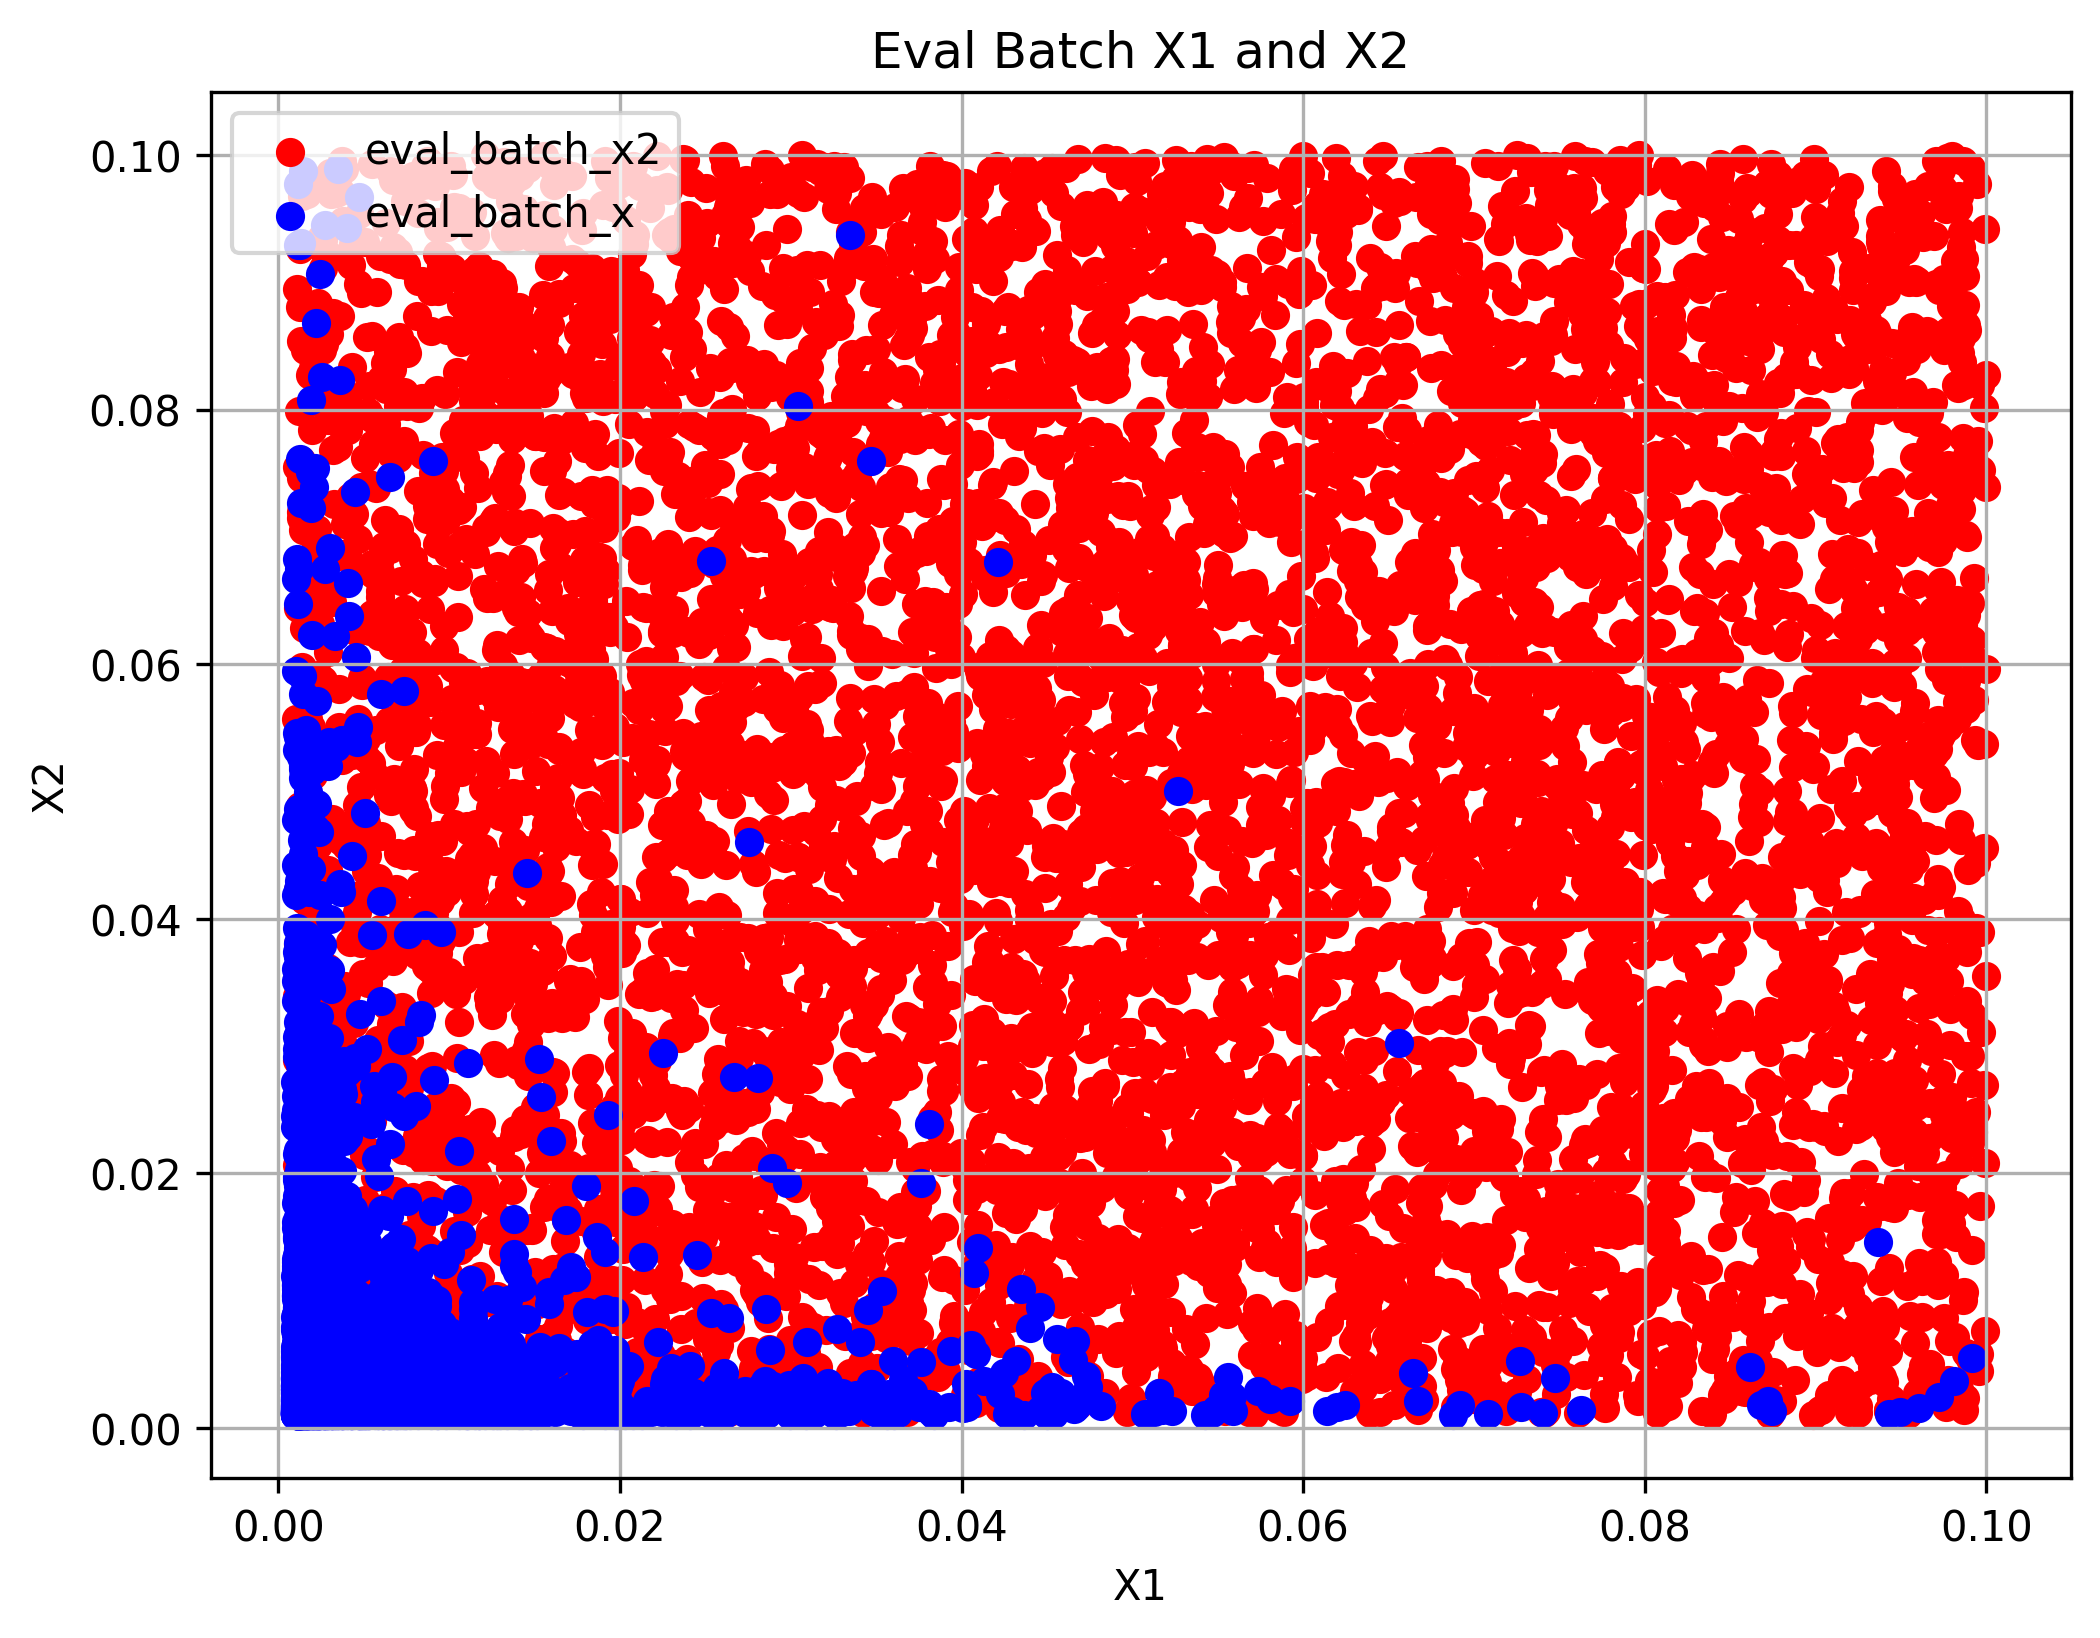

998.77875


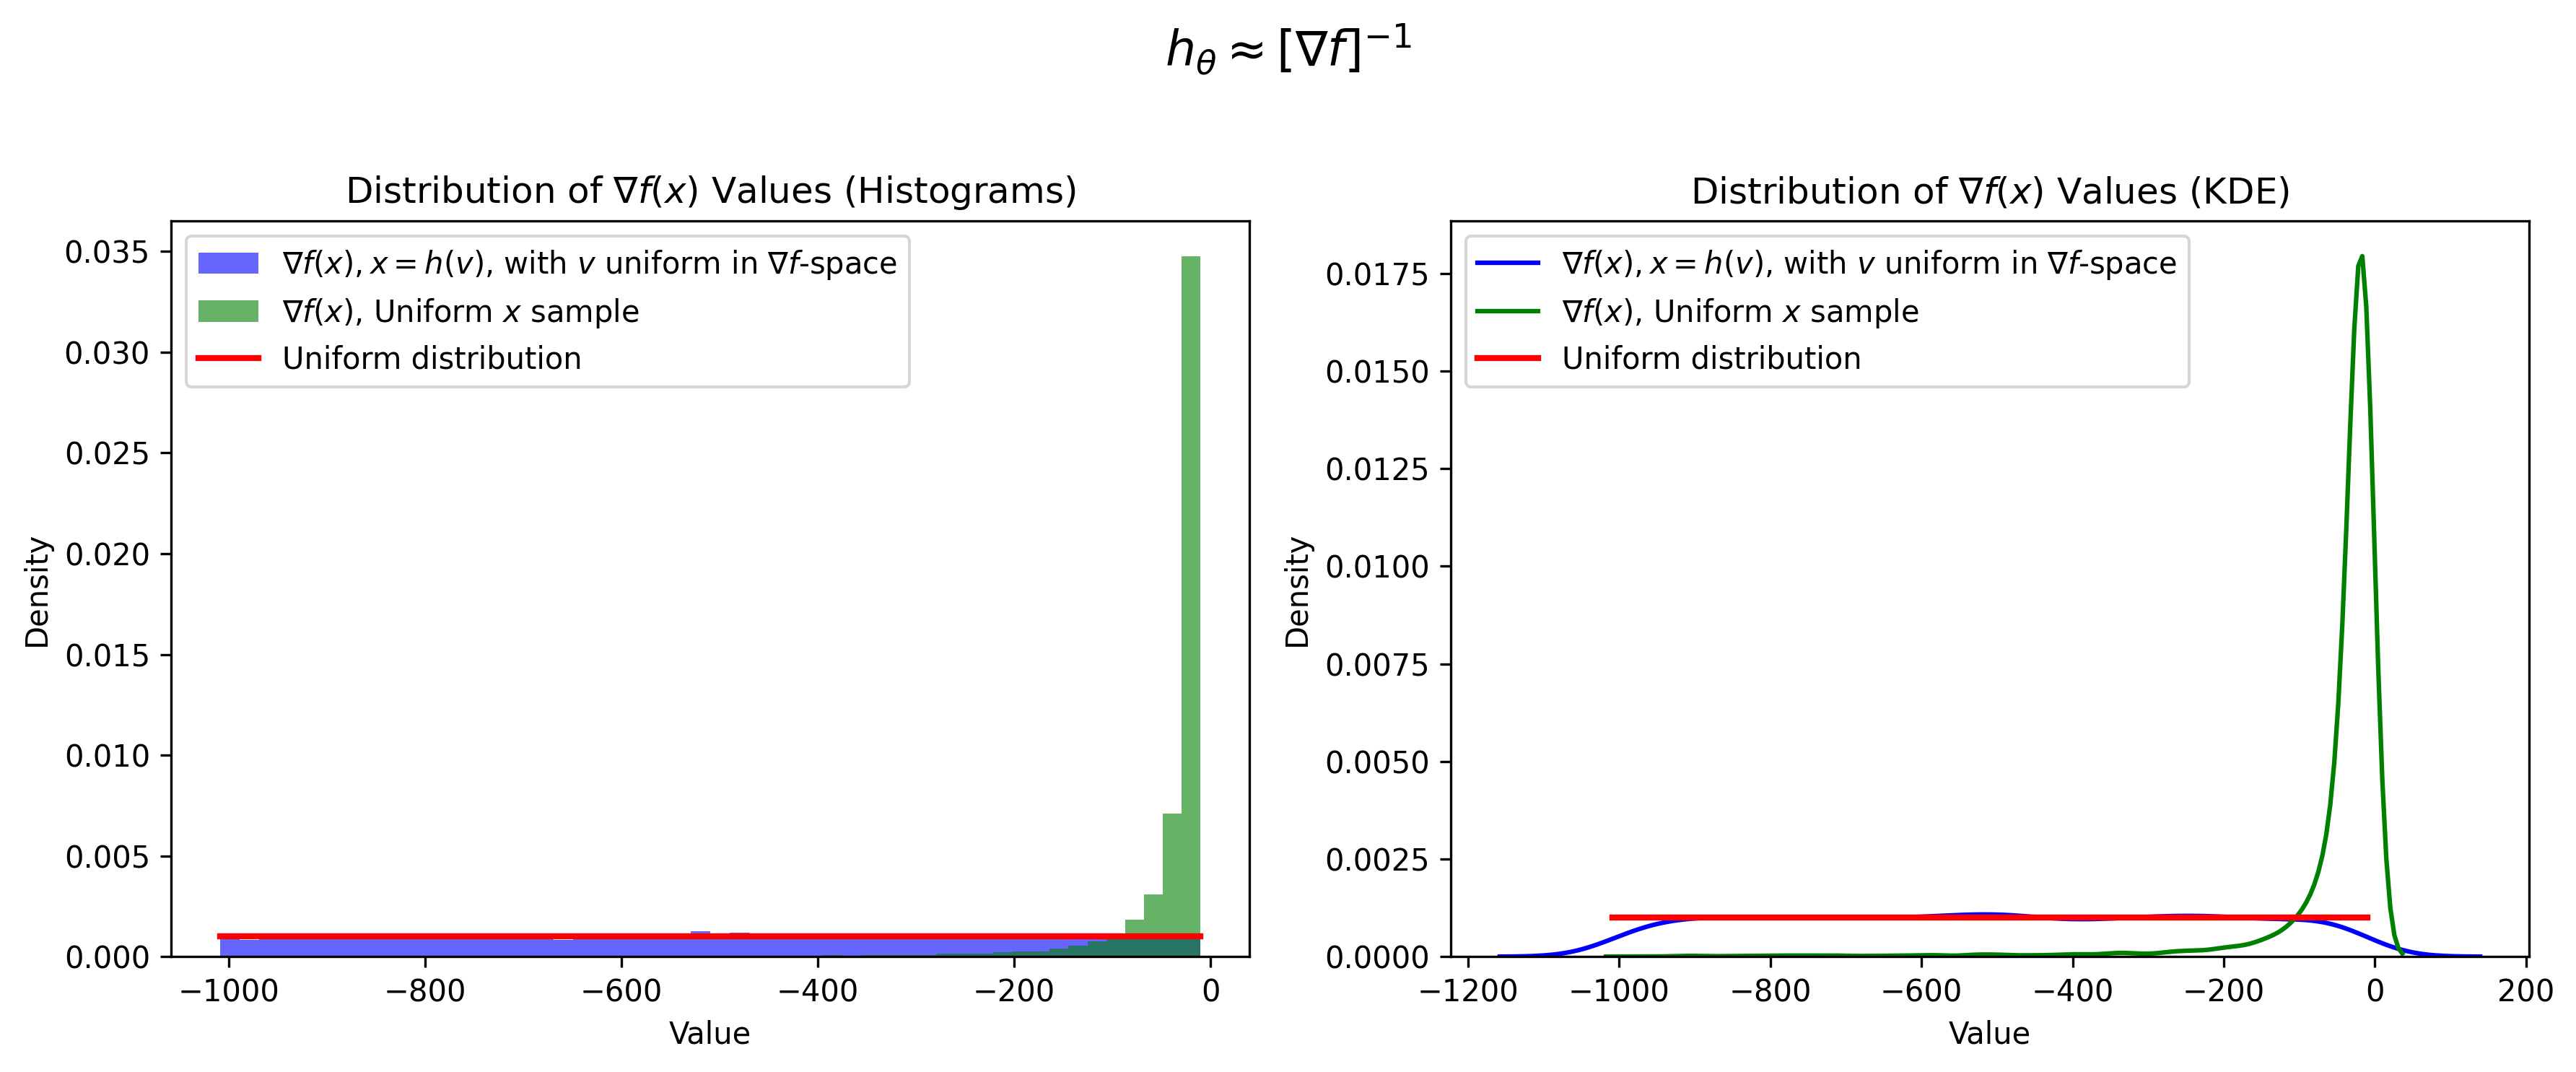

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions(x_inverse_sampling, x_uniform_sampling, psi, bins=50, figsize=(12, 5)):
    # Generate data
    x_uniform = next(x_uniform_sampling)
    x = next(x_inverse_sampling)

    plt.figure(figsize=(8, 6), dpi=DPI)  # Set the DPI to 300

    plt.scatter(x_uniform[:, 0], x_uniform[:, 1], c='red', label='eval_batch_x2')
    plt.scatter(x[:, 0], x[:, 1], c='blue', label='eval_batch_x')

    plt.title(f'Eval Batch X1 and X2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)

    plt.show()

    # Select one dimension to analyze (e.g., the first dimension)
    selected_values = np.array([psi(xi) for xi in x])[:, 0]
    uniform_values = np.array([psi(xj) for xj in x_uniform])[:, 0]

    # Calculate the interval length
    minval = min(selected_values.min(), uniform_values.min())
    maxval = max(selected_values.max(), uniform_values.max())
    interval_length = maxval - minval

    print(interval_length)

    # Create a figure and subplots with DPI set to 300
    fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=DPI)

    # Plot histograms on the first subplot
    axs[0].hist(selected_values, bins=bins, density=True, alpha=0.6, color='blue',
                label='$\\nabla f (x), x = h(v)$, with $v$ uniform in $\\nabla f$-space')
    axs[0].hist(uniform_values, bins=bins, density=True, alpha=0.6, color='green',
                label='$\\nabla f (x)$, Uniform $x$ sample')
    axs[0].plot([minval, maxval], [1 / interval_length, 1 / interval_length], color='red',
                linestyle='-', linewidth=2, label='Uniform distribution')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Density')
    axs[0].legend()
    axs[0].set_title('Distribution of $\\nabla f (x)$ Values (Histograms)')

    # Plot KDEs on the second subplot
    sns.kdeplot(selected_values, label='$\\nabla f (x), x = h(v)$, with $v$ uniform in $\\nabla f$-space',
                color='blue', ax=axs[1])
    sns.kdeplot(uniform_values, label='$\\nabla f (x)$, Uniform $x$ sample', color='green', ax=axs[1])
    axs[1].plot([minval, maxval], [1 / interval_length, 1 / interval_length], color='red',
                linestyle='-', linewidth=2, label='Uniform distribution')
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Density')
    axs[1].legend()
    axs[1].set_title('Distribution of $\\nabla f (x)$ Values (KDE)')

    # Add LaTeX notation to indicate $h_\theta$ approximation
    fig.suptitle('$h_\\theta \\approx [\\nabla f]^{-1}$', fontsize=16)

    # Adjust spacing between subplots and show the plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for suptitle
    plt.show()

# usage
plot_distributions(x_inverse_sampling, x_uniform_sampling, psi)


In [ ]:
# test_x = x_inverse_sampling#x_inverse_sampling #if cfg.test_sampling else x_uniform_sampling
# test_x2 = x_uniform_sampling

# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
# eval_batch_x2, eval_y2, eval_grad_f_x2 = get_next_batch(test_x2)

# plt.figure(figsize=(8, 6))

# plt.scatter(eval_batch_x[:, 0], eval_batch_x[:, 1], c='blue', label='eval_batch_x')
# plt.scatter(eval_batch_x2[:, 0], eval_batch_x2[:, 1], c='red', label='eval_batch_x2')

# plt.title(f'Eval Batch X1 and X2 at Epoch {epoch}')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend()
# plt.grid(True)

# plt.show()

## Train the model:

In [ ]:
x_inverse_sampling = create_inverse_uniform_sampling_random_generator(cfg, key, cfg.minval, cfg.maxval, encoder_params, apply_encoder) # approximate inverse of nu: ~ [nabla f]^-1 (mu)
x_uniform_sampling = x_uniform_sampling_generator(cfg, key, minval_x=cfg.start, maxval_x=cfg.end) # uniform in C
y_uniform_sampling = y_uniform_sampling_generator(cfg, key, minval_y=cfg.minval, maxval_y=cfg.maxval) # uniform in D

In [ ]:
def get_next_batch(train_generator):
    # Define the range and resolution for each dimension
    start = cfg.start
    end = cfg.end
    num_points = 0 #cfg.n
    useGrid = False #cfg.use_grid

    if useGrid:
        # Create d-dimensional meshgrid
        meshgrids = [jnp.linspace(start, end, num_points) for _ in range(d)]
        meshgrid_dD = jnp.stack(jnp.meshgrid(*meshgrids), axis=-1)
        x = meshgrid_dD.reshape((-1, d))
        f_x = vmap_f(x).reshape((-1, 1))
        grad_f_x = vmap_grad_f(x).reshape((-1, d))
    else:  # Use mini-batch approach
        x = next(train_generator).reshape((-1, d))
        f_x = vmap_f(x).reshape((-1, 1))
        grad_f_x = vmap_grad_f(x).reshape((-1, d))

    return x, f_x, grad_f_x

In [ ]:
# Initialize loss list to store the training loss values
Loss = []
d = cfg.dim
layer_sizes = cfg.layer_widths
initial_key = jax.random.PRNGKey(0)

# Function mappings
f = function_mapping[cfg.f_func]
f_star_true = function_mapping[cfg.f_func_star]

train_x = x_inverse_sampling if cfg.train_sampling else x_uniform_sampling
test_x = x_inverse_sampling if cfg.test_sampling else x_uniform_sampling
test_x2 = x_uniform_sampling
test_y = y_uniform_sampling  # Sample from the target distribution nu

# Initialize the model
layer_widths = cfg.layer_widths
model = ConvexNN(activation=nn.softplus, layer_widths=layer_widths)

key = random.PRNGKey(0)
x_dummy = jnp.ones((1, d))
params = model.init(key, x_dummy)['params']

# Learning rate setup
initial_learning_rate = 3e-2
min_learning_rate = 1e-9
lr_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=1000,
    decay_rate=0.95,
    end_value=min_learning_rate,
    staircase=True
)

# Define gradient clipping transformation and optimizer
grad_clip = optax.clip_by_global_norm(1.0)
optimizer = optax.chain(
    grad_clip,
    optax.adam(learning_rate=lr_schedule)
)

# Training state
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

@jax.jit
def train_step(state, inputs_x, inputs_y, targets):
    """
    Perform a training step using inputs_x, inputs_y, and targets.
    """
    def pure_loss_fn(params, inputs_x, inputs_y, targets):
        # Compute predictions using the model
        predictions = jnp.sum(inputs_x * inputs_y, axis=-1).reshape(-1, 1) - \
                      jnp.squeeze(state.apply_fn({'params': params}, inputs_y)).reshape(-1, 1)

        # Calculate mean squared error loss
        loss = jnp.mean((predictions - targets.reshape(-1, 1)) ** 2)
        return loss

    # Compute gradients and update model parameters
    loss_fn = partial(pure_loss_fn, inputs_x=inputs_x, inputs_y=inputs_y, targets=targets)
    grads = jax.grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    loss_value = loss_fn(state.params)
    return new_state, loss_value

# Updated LOSS function for evaluation and plotting
def print_loss_fn(params, inputs_x, inputs_y, targets, use_regularizer=False):
    """
    Calculate loss for evaluation or plotting purposes.
    """
    def pure_loss_fn(params, inputs_x, inputs_y, targets):
        predictions = jnp.sum(inputs_x * inputs_y, axis=-1).reshape(-1, 1) - \
                      jnp.squeeze(state.apply_fn({'params': params}, inputs_y)).reshape(-1, 1)
        loss = jnp.mean((predictions - targets.reshape(-1, 1)) ** 2)
        return loss

    return pure_loss_fn(params, inputs_x, inputs_y, targets)


In [42]:
def print_samples(y, x, train_f_x, num_samples=5):
    """
    Helper function to print the first few samples of y, x, and train_f_x.
    """
    print("\nSample values:")
    print("=" * 40)
    for i in range(min(num_samples, y.shape[0])):
        print(f"y[{i}]       = {y[i]}")
        print(f"x[{i}]       = {x[i]}")
        print(f"train_f_x[{i}] = {train_f_x[i]}")
        print("-" * 40)
    print("=" * 40)


# Initialize timing and progress tracking
tic = time.time()
epoch = 0
N =20000 #cfg.num_epochs
pbar = tqdm(total=N, desc="Processing", position=0, leave=True)

converged = False
best_rmse = float('inf')
best_epoch = 0

# Lists to store losses and evaluation metrics
train_losses = []
eval_losses = []
statistics_list = []

# Initialize RMSE1 to prevent NameError
RMSE1 = float('inf')

while epoch < N:
    # Sample y directly and compute x using the encoder
    key, subkey = jax.random.split(key)
    y = generate_y_samples_uniformly(subkey, cfg.batch_size, cfg.dim, cfg.minval, cfg.maxval)

    # Calculate x using the encoder and compute the target f(x)
    x = apply_encoder(encoder_params, y)
    train_f_x = vmap(f)(x)  # Compute f(x) as the target

    # Print the samples for debugging
    # print_samples(y, x, train_f_x, num_samples=5)

    current_lr = lr_schedule(epoch)

    # Training step
    for _ in range(cfg.steps):
        state, loss_value = train_step(state, x, y, train_f_x)
        pbar.update(1)

    epoch += 1
    train_losses.append(loss_value)

    # print("losssssss = ", loss_value)

    # Periodic evaluation
    if epoch % 10000 == 0 or epoch == N - 1:
        # Evaluation on test set 1 (approximate inverse)
        y_test1 = generate_y_samples_uniformly(subkey, cfg.batch_size, cfg.dim, cfg.minval, cfg.maxval)
        x_test1 = apply_encoder(encoder_params, y_test1)
        eval_f_x_test1 = vmap(f)(x_test1)

        # Evaluate using the updated loss function
        eval_loss_value = print_loss_fn(state.params, x_test1, y_test1, eval_f_x_test1)
        # Print the samples for debugging
        # print_samples(y_test1, x_test1, eval_f_x_test1, num_samples=2)
        preds1 = model.apply({'params': state.params}, y_test1)
        acc1, acc_max1, mre1 = calculate_statistics(y_test1, preds1, vmap_f_star_true)
        RMSE1 = jnp.sqrt(eval_loss_value)
        eval_losses.append(eval_loss_value)

    # Print progress and current loss
        tqdm.write(f"\n Epoch {epoch}, Loss: {loss_value:.6f}, LR: {current_lr:.6f}")
        tqdm.write(f"Test RMSE after {epoch} epochs = {RMSE1:.4f}")

pbar.close()

# Convert the losses to floats for easier analysis
train_loss_list = [float(value) for value in train_losses]
eval_loss_list = [float(value) for value in eval_losses]


Processing:  50%|█████     | 10010/20000 [02:30<07:24, 22.49it/s]


 Epoch 10000, Loss: 0.033877, LR: 0.018907
Test RMSE after 10000 epochs = 0.1278


Processing: 100%|██████████| 20000/20000 [04:59<00:00, 66.73it/s]



 Epoch 19999, Loss: 0.025532, LR: 0.011321
Test RMSE after 19999 epochs = 0.1470

 Epoch 20000, Loss: 0.021579, LR: 0.011321
Test RMSE after 20000 epochs = 0.0725


NameError: name 'x_test1' is not defined

In [45]:
from datetime import timedelta

# Find the statistics corresponding to the best RMSE
best_stat = min(statistics_list, key=lambda x: x['best_rmse'])

# Function to print a separator line for clarity
def print_separator(char='-', length=50):
    print(char * length)

# Print the best evaluation results
print_separator('=')
print("\nBest Evaluation Results:")
print_separator('=')
print(f"\nEvaluation after {best_stat['epoch']} epochs:")
print(f"Train Loss      = {best_stat['train_loss']:.6f}")
print(f"Eval Loss       = {best_stat['eval_loss']:.6f}")
print(f"Best RMSE       = {best_stat['best_rmse']:.6f} at epoch {best_stat['best_epoch']}")

# Format and print the total runtime
runtime_seconds = best_stat['runtime']
runtime_formatted = str(timedelta(seconds=runtime_seconds))
print(f"Total Runtime   = {runtime_formatted}")

# Print results for the approximate distribution (approx_nu ~ nu in D)
print_separator()
print(f"\nMeasure approx_nu (approx_nu ~ nu in D) results:")
print(f"Accuracy        = {best_stat['accuracy_mu1']:.6f}")
print(f"Max Accuracy    = {best_stat['max_accuracy_mu1']:.6f}")
print(f"RMSE            = {best_stat['residual_mu1']:.6f}")
print(f"Mean Rel Error  = {best_stat['mean_relative_error_mu1']:.6f}")

# Print results for the 'nu' distribution
print_separator()
print(f"\nMeasure 'nu' results:")
print(f"Accuracy (y_nu) = {best_stat['accuracy_y_nu']:.6f}")
print(f"Max Accuracy    = {best_stat['max_accuracy_y_nu']:.6f}")
print(f"Mean Rel Error  = {best_stat['mean_relative_error_y_nu']:.6f}")

# Additional evaluation on the second test set
print_separator()
print(f"\nAdditional Test on Test Set 2 after {best_stat['epoch']} epochs:")
print(f"Eval Loss 2     = {best_stat['eval_loss_2']:.6f}")
print(f"Accuracy 2      = {best_stat['accuracy_mu2']:.6f}")
print(f"Max Accuracy 2  = {best_stat['max_accuracy_mu2']:.6f}")
print(f"RMSE 2          = {best_stat['residual_mu2']:.6f}")
print(f"Mean Rel Error 2= {best_stat['mean_relative_error_mu2']:.6f}")
print_separator('=')


ValueError: min() arg is an empty sequence

In [ ]:
# test_x = x_inverse_sampling#x_inverse_sampling #if cfg.test_sampling else x_uniform_sampling
# test_x2 = x_uniform_sampling

# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
# eval_batch_x2, eval_y2, eval_grad_f_x2 = get_next_batch(test_x2)

# plt.figure(figsize=(8, 6))

# plt.scatter(eval_batch_x[:, 0], eval_batch_x[:, 1], c='blue', label='eval_batch_x')
# plt.scatter(eval_batch_x2[:, 0], eval_batch_x2[:, 1], c='red', label='eval_batch_x2')

# plt.title(f'Eval Batch X1 and X2 at Epoch {epoch}')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend()
# plt.grid(True)

# plt.show()

## Plot section of the graph

In [46]:
minval = cfg.minval  # = minval_y
maxval = cfg.maxval  # = maxval_y

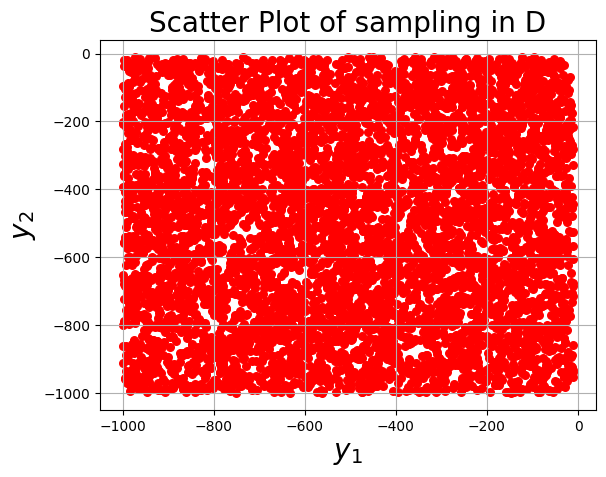

Processing:   0%|          | 261/200000 [17:54<228:24:22,  4.12s/it]


Residual along axis 0 @ value = -505.0: 0.060027968138456345
ax =  1


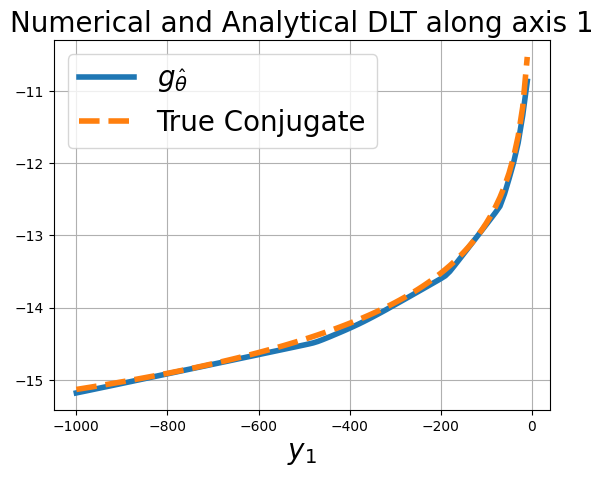

Residual along axis 1 @ value = -505.0: 0.06229127198457718
ax =  2


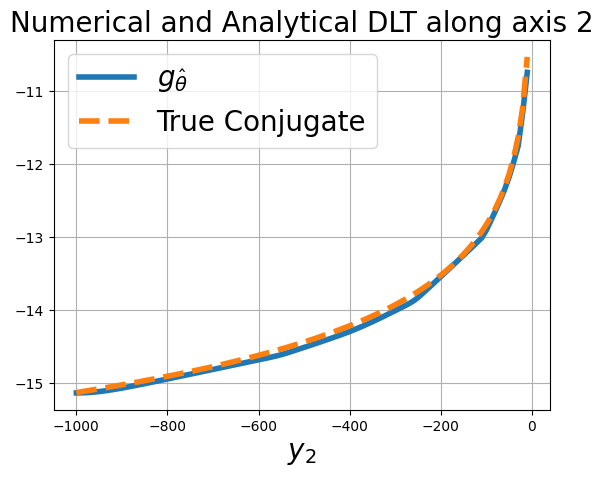

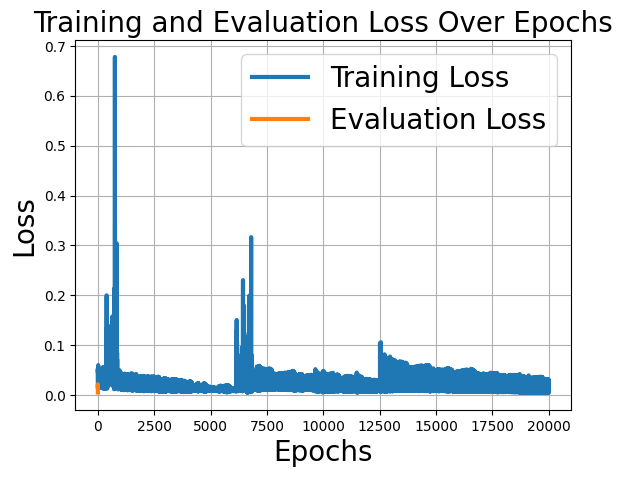

-1000 -10


In [50]:
const_val = (minval + maxval)/2

plot_results(d, y, preds1, vmap_f_star_true, state, const_val, train_losses, eval_losses)

print(minval, maxval)

In [ ]:
# loss_list = [float(value) for value in Loss]

# # Print the result
# print(loss_list)

In [ ]:
# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(train_x)
# preds = jnp.squeeze(state.apply_fn({'params': state.params}, eval_grad_f_x)).reshape(-1, 1)
# accuracy,acc_max, residual, mre = calculate_statistics(eval_batch_x, eval_grad_f_x, preds, vmap_f_star_true,  train_loss_list, eval_loss_list)
# print("Accuracy:", accuracy)
# print("Accuracy max norm:", acc_max)
# print("Accuracy, rel:", mre)
# print("Residual:", residual)


Best Evaluation Results:

Evaluation after 199998 epochs:
Train Loss = 0.000036
Eval Loss = 0.000036
Best RMSE = 0.005966 at epoch 199998

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 0.005966312251985073, Max Accuracy = 0.03135490417480469, RMSE = 0.005966, Mean Relative Error = 0.000350

Measure 'nu' results
Accuracy (y_nu) = 0.0059197451919317245, Max Accuracy (y_nu) = 0.025862693786621094, Mean Relative Error (y_nu) = 0.000345
Additional Test on Test Set 2 after 199998 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 0.000089
Accuracy 2 = 0.009454213082790375, Max Accuracy 2 = 0.03984355926513672, RMSE 2 = 0.009454, Mean Relative Error 2 = 0.000898

### RESULTS FOR THE DLT PAPER:
d = 2
L2 Accuracy = 0.009454213082790375 (direct sampling)
L-2 Accuracy (y_nu) = 0.0059197451919317245 (target uniform measure)

Train the best example Runtime = 52:00
Total runtime for 200k itereations = 52:00

Autoencoder training runtime: 46.97 seconds
Autoencoder loss: 0.03
